Currently the requirements to get IV estimates are:
 - Your player level (which must remain constant as you're leveling this pokémon)
 - The pokémon's CP, HP, and stardust requirements for the next level
 - Every additional line of data added must be from only one power up (i.e. don't power up many times without also including those values in the table
 
 In the near future I'll add the ability to:
 - Specify the pokémon's level or a range of levels to add in as a prior (e.g. your guess from the CP arc)
 - Indicate you're missing some data on particular power-up levels
 - Indicate that you're missing an unknown number of power up levels 


### What is your player level?

In [47]:
player_level = 40

### What is the pokémon's name? (type in quote marks)

In [48]:
pokemonName= "sandshrew"
#pokemonName= "scyther"
#pokemonName= "lapras"
pokemonName= "pidgey"
#pokemonName= "rhyhorn"
#pokemonName= "squirtle"
#pokemonName= "magikarp"
#pokemonName= "weepingbell"
#pokemonName= "hypno"

### Datasets! Put in the pokémon's CP, HP, and stardust to level 

In [49]:
dataset=[(232,42,1900)] #pidgey
dataset=[(1095,131,1600)] #evil lapras
dataset=[(219,47,1000), #mudball Jnr lv 1
        (230,48,1000), #mudball Jnr lv 2
        (241,50,1300)] #mudball Jnr lv 3
dataset=[(287,36,1900)] #ekans1
dataset=[(246,35,1300)] #ekans2
dataset=[(174,53,600), #rhyhorn lv 1
        (191,55,600), #rhyhorn lv 2
        (209,58,600), #rhyhorn lv 3
        (226,60,800)] #rhyhorn lv 4
dataset=[(727,83,1300), #Hypno lv 1
        (758,85,1300), #Hypno lv 2
        (788,87,1600)] #Hypno lv 3
#dataset=[(540,60,1300), #Weepingbell lv 1
#        (563,61,1300), #Weepingbell lv 2
#        (585,62,1600)] #Weepingbell lv 3
dataset=[(237,45,1600), #pidgey lv 1
        (246,46,1600), #pidgey lv 2
        (255,47,1600), #pidgey lv 3
        (264,48,1600), #pidgey lv 4
        (273,49,1900), #pidgey lv 5 (I had CP 272 down probably a typo)
        (283,49,1900), #pidgey lv 6
        (292,50,1900), #pidgey lv 7
        (301,51,1900)] #pidgey lv 8 (but can't level)
#dataset=[(1047,81,2500)] #scyther
#dataset=[(577,63,3000)] #squirtle
#dataset=[(54,19,800)] #magikarp

##### Code is going to chug along now

max possible CP for any pidgey 679.0
max possible HP for any pidgey 75.0

Number of possible stamina, attack and defense ivs, and levels:  1

All possible combinations:
level: 16.5   ivs: stamina:  15   attack: 11   defense: 10   probability: 100.0 %


Probability of perfect ivs (given any possible level):  0.0 %
Probability of two perfect ivs (given any possible level):  0.0 %
Probability of one perfect iv (given any possible level):  100.0 %
Probability of three 14/15 ivs (given any possible level):  0.0 %
Probability of two 14/15 ivs (given any possible level):  0.0 %

Now considering on a level-by-level basis: 
Possible IVs for level 16.5:


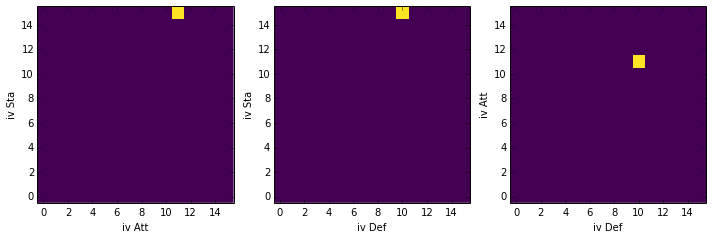

In [51]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import viridis
plt.register_cmap(name='viridis', cmap=viridis.viridis)
plt.set_cmap(viridis.viridis)
import pokedicts as pd


#HP IV calc is easiest
#HP = MAX(10,FLOOR((basestamina + ivstamina)*TotalCPMultiplier)) (is it floored/10?)

#CP = MAX(10,FLOOR(HP**0.5*Attack*Def**0.5/10))
#where
#Attack = (baseatt + ivatt)*TotalCPMultiplier
#Defense= (basedef + ivdef)*TotalCPMultiplier

#CP= MAX(10,FLOOR( (basesta+ivsta)**2 * (basedef+ivatt) * (basedef+ivdef)**2 ) * TCpM**2/10)
#CP=f(ivsta,ivatt,ivdef,level)
#HP=g(ivsta,level)

#I can calculate p(CP|ivsta,ivatt,ivdef,level), p(HP|ivsta,level), p(stardust|level)

#Easiest thing to do would be to calculate all values? 16 x 16 x 16 x 79 pokemon levels?
#Can do 16x16x16 itself and then use matrix multiplication to work out the other



############## MODEL CONSTRUCTION (all possible results) #####################


#fetch the data from pokemon name
baseSta,baseAtt,baseDef=pd.pokemonToBaseStats[pokemonName.title()]

# 1d map all possible pokemon levels
map1d_level=(np.arange(79)+2.)/2.

# 1d map all possible IVs
map1d_ivatt=np.arange(16)
map1d_ivdef=np.arange(16)
map1d_ivsta=np.arange(16)


#all CP modifier values, 1d and 4d
map1d_TCpM= np.array([pd.levelToTCpM[i] for i in map1d_level])

#all possible attack, def, stamina values (all possible levels)
map1d_att=map1d_ivatt+baseAtt
map1d_def=map1d_ivdef+baseDef
map1d_sta=map1d_ivsta+baseSta

#Making 4D array of variables and partial calculations
map_sta, map_att, map_def, map_TCpM=np.meshgrid(map1d_sta,map1d_att,\
                                                 map1d_def,map1d_TCpM, indexing='ij')

map_ivsta, map_ivatt, map_ivdef, map_level=np.meshgrid(map1d_ivsta,map1d_ivatt,\
                                                 map1d_ivdef,map1d_level, indexing='ij')


#all possible CP values 
allPossibleCP = np.floor((map_sta**0.5*map_att*map_def**0.5*map_TCpM**2)/10.)
allPossibleCP[allPossibleCP<10]=10

#all possible HP values
allPossibleHP =np.floor(map_sta*map_TCpM) 
allPossibleHP[allPossibleHP<10]=10

#all possible Stardust values
allPossibleSD=np.array([pd.levelToStardust[i] \
                        for i in map_level.ravel()]).reshape(map_level.shape)



#From those three 4D arrays we have a model in StAtDeLv space tah dah




############## INITIAL PRIOR CONSTRUCTION ##################
#Construct initial (uninformative) prior:
prior_STATDELV=np.ones(map_sta.shape,dtype="float")

#Immediately apply player level prior (could just do the stardust but want to decouple)
prior_STATDELV[ map_level > player_level] = 0

#Stardust counts as an observation so won't apply as an initial prior

#normalise prior
prior_STATDELV/=np.sum(prior_STATDELV)




############# LOOP OVER THE DATA ####################

#Fetch data from set 
for data in dataset:
    dataCP,dataHP,dataSD=data

    LH_CP=(allPossibleCP == dataCP) #this is in STATDELV space
    LH_HP=(allPossibleHP == dataHP)
    LH_SD=(allPossibleSD == dataSD)


    LH_Joint=np.array(LH_CP*LH_HP*LH_SD,dtype="float" )

    #print np.sum(LH_CP*LH_HP)
    #print np.sum(LH_CP*LH_SD)
    #print np.sum(LH_HP*LH_SD)

    #Fold in the previous posterior (or initial prior) as a prior 
    LH_Joint*=prior_STATDELV
    LH_Joint/=np.sum(LH_Joint)

    # Need to pass this posterior to prior_StAtDeLv, BUT with level incremented by 0.5, 
    # So shifted along one in space...
    # Zero lv 1 first 
    prior_STATDELV[:,:,:,0]=0
    # Copy over shifting in space 
    prior_STATDELV[:,:,:,1:]=LH_Joint[:,:,:,:-1]



#Print out some fun facts from the model 
#print "min/max possible stardust", np.min(allPossibleSD), np.max(allPossibleSD)
print "max possible CP for any",pokemonName,np.max(allPossibleCP)
print "max possible HP for any",pokemonName,np.max(allPossibleHP)



print "\nNumber of possible stamina, attack and defense ivs, and levels: ", np.sum((LH_Joint > 0))
#Fold in the previous posterior as a prior

#print "possible iv HP values given HP:",list(set(map_sta[LH_HP]-baseSta))
#print "possible iv HP values given SD:",list(set(map_sta[LH_SD]-baseSta))
#print "possible levels given HP: ",list(set(map_level[LH_HP]))
#print "possible levels given SD: ",list(set(map_level[LH_SD]))


############## Finding Different Stats :) ################

LH_ind=np.where(LH_Joint > 0)
#find all cominations of ivs and lvs
possible_STATDELV=np.array([map_ivsta[LH_ind],\
                            map_ivatt[LH_ind],\
                            map_ivdef[LH_ind],\
                            map_level[LH_ind]]).T



print "\nAll possible combinations:"
for i, vals in enumerate(possible_STATDELV):
    print "level:", vals[3], \
        "  ivs: stamina: ", int(vals[0]), \
        "  attack:", int(vals[1]), \
        "  defense:",int(vals[2]), \
        "  probability:",np.round(LH_Joint[LH_ind[0][i],LH_ind[1][i],LH_ind[2][i],LH_ind[3][i]]*100,3),'%'
        
#Perfect IVs
print "\n\nProbability of perfect ivs (given any possible level): ",\
                    np.round(np.sum(LH_Joint[15,15,15,:])*100 , 3),'%'
    
#Two perfect IVs 
test_ind=np.where(((map_ivsta==15) & (map_ivatt==15)) |\
                  ((map_ivsta==15) & (map_ivdef==15)) |\
                  ((map_ivatt==15) & (map_ivdef==15)))
print "Probability of two perfect ivs (given any possible level): ",\
                    np.round(100*np.sum(LH_Joint[test_ind]), 3),'%'

#One perfect IV
test_ind=np.where(  (map_ivsta==15) | (map_ivatt==15) | (map_ivdef==15)  )
print "Probability of one perfect iv (given any possible level): ",\
                    np.round(100*np.sum(LH_Joint[test_ind]), 3),'%'

#Three top two IVs
test_ind=np.where(  (map_ivsta>=14) & (map_ivatt>=14) & (map_ivdef>=14)  )
print "Probability of three 14/15 ivs (given any possible level): ",\
                    np.round(100*np.sum(LH_Joint[test_ind]), 3),'%'

#Two top two IVs
test_ind=np.where(((map_ivsta>=14) & (map_ivatt>=14)) |\
                  ((map_ivsta>=14) & (map_ivdef>=14)) |\
                  ((map_ivatt>=14) & (map_ivdef>=14)))
print "Probability of two 14/15 ivs (given any possible level): ",\
                    np.round(100*np.sum(LH_Joint[test_ind]), 3),'%'





#Giving stats for each level     
print "\nNow considering on a level-by-level basis: "
for lv in np.sort(list(set(map_level[LH_ind]))):
    print "Possible IVs for level "+str(lv)+":"
    plt.figure(figsize=(10,10))
    ###sta vs att
    plt.subplot(1,3,1)
    plt.imshow(np.sum(LH_Joint[:,:,:,int((lv-1)*2)]*100,axis=2),\
               interpolation="None",origin="lower")
    plt.xlabel("iv Att")
    plt.ylabel("iv Sta")

    ###sta vs def
    plt.subplot(1,3,2)
    plt.imshow(np.sum(LH_Joint[:,:,:,int((lv-1)*2)]*100,axis=1),\
               interpolation="None",origin="lower")
    plt.xlabel("iv Def")
    plt.ylabel("iv Sta")
    
    ###att vs def
    plt.subplot(1,3,3)
    plt.imshow(np.sum(LH_Joint[:,:,:,int((lv-1)*2)]*100,axis=0),\
               interpolation="None",origin="lower")
    plt.xlabel("iv Def")
    plt.ylabel("iv Att")
    plt.tight_layout()
    plt.show()
    
    

## Everything below is broken uncommented trash atm

In [6]:
## Working out probabilities of finding these data values randomly


#Setting up the real CP/HP/SD values, their indices and a dictionary
map1d_CP=np.arange(800,dtype='float')+10
CPtoIndex=dict(zip(map1d_CP,np.arange(len(map1d_CP),dtype='float')))
               
map1d_HP=np.arange(200,dtype='float')+10
HPtoIndex=dict(zip(map1d_HP,np.arange(len(map1d_HP),dtype='float')))

map1d_SD=np.sort(np.array(list(set(np.array(\
                    [pd.levelToStardust[lvl] for lvl in map1d_level],dtype='float')))))
SDtoIndex=dict(zip(map1d_SD, np.arange(len(map1d_SD),dtype='float')))


countsCPHPSD=np.zeros((map1d_CP.shape[0],map1d_HP.shape[0],map1d_SD.shape[0]),dtype="float")

flatCP=allPossibleCP.flatten()
flatHP=allPossibleHP.flatten()
flatSD=allPossibleSD.flatten()


flatCPHPSD=np.array([flatCP,flatHP,flatSD]).T


print "\n\ncalculating bayesian evidence??? (few seconds)"
for CPHPSD in flatCPHPSD:
    #print CPtoIndex[CPHPSD[0]], HPtoIndex[CPHPSD[1]],SDtoIndex[CPHPSD[2]]
    countsCPHPSD[ CPtoIndex[CPHPSD[0]] , HPtoIndex[CPHPSD[1]] , SDtoIndex[CPHPSD[2]] ] +=1

#marginalise
countsCPHPSD/=np.sum(countsCPHPSD)

#Collapse counts down along axes)
countsCP=[np.sum(countsCPHPSD[i,:,:]) for i in range(len(countsCPHPSD[:,0,0]))]
countsHP=[np.sum(countsCPHPSD[:,i,:]) for i in range(len(countsCPHPSD[0,:,0]))]
countsSD=[np.sum(countsCPHPSD[:,:,i]) for i in range(len(countsCPHPSD[0,0,:]))]


plt.plot(map1d_CP,countsCP)
plt.show()

plt.plot(map1d_HP,countsHP)
plt.show()

plt.plot(map1d_SD,countsSD)
plt.show()



calculating bayesian evidence??? (few seconds)


/Library/Python/2.7/site-packages/ipykernel/__main__.py:28: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


KeyError: 817.0